In [1]:
%reset
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from functions import loader, splt, fitter, stats, grouper
import matplotlib.pyplot as plt

savedir = "G01/"

In [4]:
all_data = loader.load_data()
data = loader.remove_duplicates( all_data,
    lambda d: ( d['dep_polymers'], d['side'], d['defects_frac'], d['gamma'] ),
    lambda d: d['runned_replicas']
)
len( data )

161

In [11]:
for d in data:
    # x, y = fitter.rebin_n( d['h_x'], d['h'], 50 )
    # d['fits'] = fitter.entropyc_fits( x, y, d, threshold=0.5, plot=False )
    d['jamming_frac_avg'] = np.mean( d['chunks'] ) / d['side'] / d['side']
    d['jamming_frac_std'] = np.std( d['chunks'], ddof = 1 ) / d['side'] / d['side']
    
    d['np_std'] = np.std( d['chunks'], ddof=1 ) / d['side'] / d['side']

In [12]:
filtered_data = data

In [13]:
loader.export( filtered_data, savedir + "data.json", columns = ['side','defects_frac','gamma','dep_polymers','runned_replicas','jamming_frac_avg','jamming_frac_std'], renames = {} )

161  rows exported to  G01/data.json


In [7]:
from functions import CEfitter

# to_use = lambda d: d['fits']['Gauss']['pars'][2]
to_use = lambda d: d['np_std']


grouped_data = grouper.extract_xy( filtered_data, ['dep_polymers', 'defects_frac', 'gamma'], lambda d: d['side'], to_use )

grouped_data = grouped_data[ np.vectorize( lambda g : len( g['x'] ) > 2 )( grouped_data ) ]

for g in grouped_data:
    g['B'], logx, logyB = CEfitter.estimate_B( g['x'] , g['y'] )
    g['oneovernu'], g['somethingrelatedtoA'] = CEfitter.estimate_oneovernu( logx, logyB )
    g['oneovernu_b'], g['somethingrelatedtoA_b'] = CEfitter.estimate_oneovernu_bis( logx, logyB )

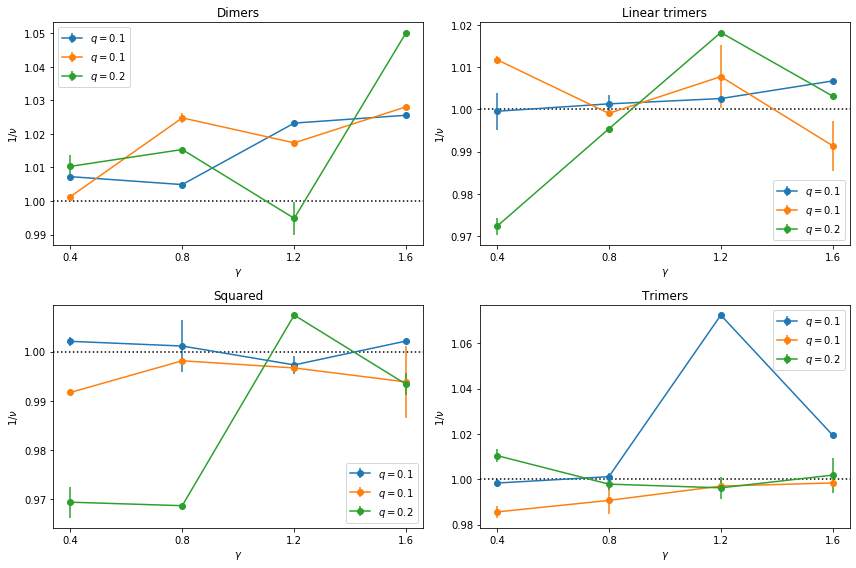

In [8]:
splt.oneitem_iterate_errorbar(
    len( grouped_data ),
    lambda d: grouped_data[d]['dep_polymers'],
    lambda d: grouped_data[d]['defects_frac'],
    lambda d: grouped_data[d]['gamma'],
    lambda d: [
        grouped_data[d]['oneovernu']
    ],
    lambda it, l: [
        { 'label': fr"$q = {l:.1f}$", 'ls': '-', 'marker': 'o' }
    ],
    lambda it: (
        plt.title( fr"{it}" ),
        plt.xlabel( fr"$\gamma$" ),
        plt.ylabel( fr"$1/\nu$" ),
        splt.hline( 1 )
    )
)

plt.tight_layout()
plt.savefig( savedir + '/oneovernu.pdf' )
plt.savefig( savedir + '/oneovernu.png' )

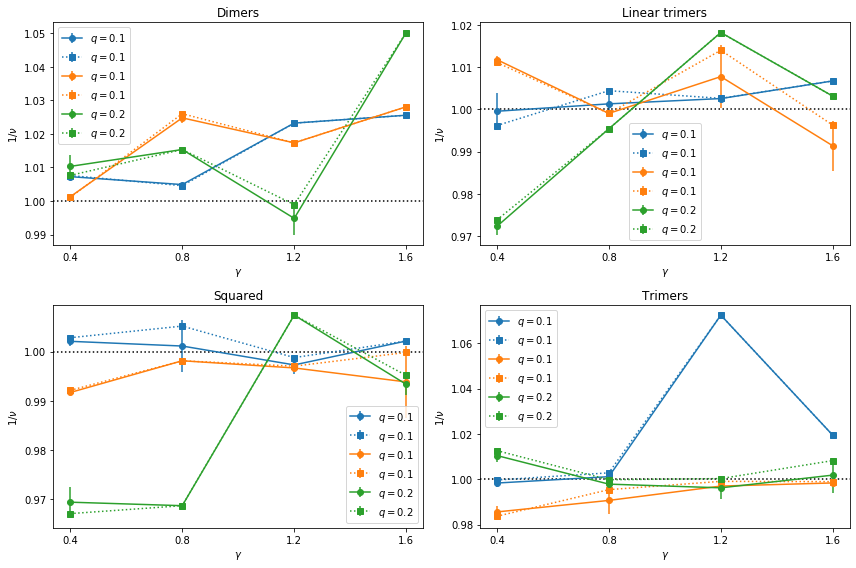

In [9]:
splt.oneitem_iterate_errorbar(
    len( grouped_data ),
    lambda d: grouped_data[d]['dep_polymers'],
    lambda d: grouped_data[d]['defects_frac'],
    lambda d: grouped_data[d]['gamma'],
    lambda d: [
        grouped_data[d]['oneovernu'],
        grouped_data[d]['oneovernu_b']
    ],
    lambda it, l: [
        { 'label': fr"$q = {l:.1f}$", 'ls': '-', 'marker': 'o' },
        { 'label': fr"$q = {l:.1f}$", 'ls': ':', 'marker': 's' }
    ],
    lambda it: (
        plt.title( fr"{it}" ),
        plt.xlabel( fr"$\gamma$" ),
        plt.ylabel( fr"$1/\nu$" ),
        splt.hline( 1 )
    )
)

plt.tight_layout()
plt.savefig( savedir + '/oneovernu_comparison.pdf' )
plt.savefig( savedir + '/oneovernu_comparison.png' )

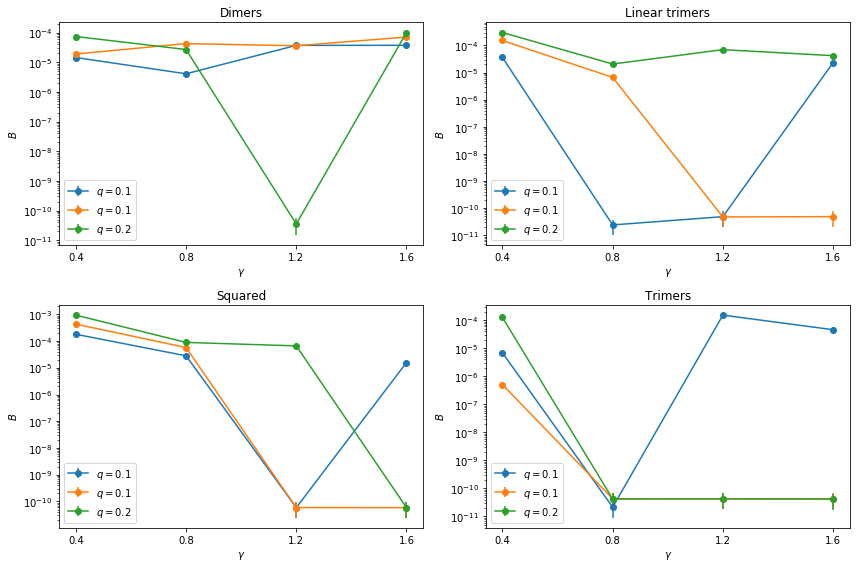

In [10]:
splt.oneitem_iterate_errorbar(
    len( grouped_data ),
    lambda d: grouped_data[d]['dep_polymers'],
    lambda d: grouped_data[d]['defects_frac'],
    lambda d: grouped_data[d]['gamma'],
    lambda d: [
        grouped_data[d]['B']
    ],
    lambda it, l: [
        { 'label': fr"$q = {l:.1f}$", 'ls': '-', 'marker': 'o' }
    ],
    lambda it: (
        plt.title( fr"{it}" ),
        plt.xlabel( fr"$\gamma$" ),
        plt.ylabel( fr"$B$" ),
        plt.yscale( 'log' )
        # splt.hline( 0 )
    )
)

plt.tight_layout()
plt.savefig( savedir + '/B.pdf' )
plt.savefig( savedir + '/B.png' )

TypeError: unsupported operand type(s) for -: 'list' and 'Variable'

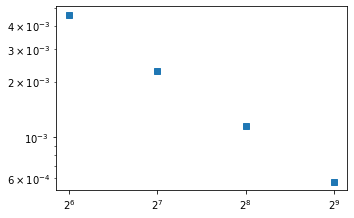

In [11]:
splt.init( len( grouped_data ) / 4 + 1, 4 )

for g in grouped_data:
    splt.next()

    plt.loglog( g['x'], g['y'], 's', label="Original data", basex = 2, basey = 10 )
    plt.plot( g['x'], g['y'] - g['B'], 'o', label="Shifted data" )

    x = np.logspace( np.log2( np.min(  g['x'] ) ), np.log2( np.max(  g['x'] ) ), 1000, base = 2 )
    plt.plot( x, np.array( x ) ** ( - g['oneovernu'].n ) * 2 ** ( g['shift'].n ), '--', label = "Shifted fit" )
    plt.plot( x, np.array( x ) ** ( - g['oneovernu'].n ) * 2 ** ( g['shift'].n ) + g['B'], '--', label = "Fit" )

    plt.legend()

    plt.xlabel( "Side" )
    plt.ylabel( fr"$\sigma_B$" )
    plt.title( fr"{g['dep_polymers']} - $q={g['defects_frac']}$ - $\gamma={g['gamma']}$")

plt.tight_layout()
plt.savefig( savedir + "fit.pdf")
plt.savefig( savedir + "fit.png")

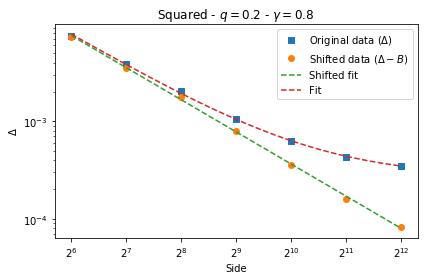

In [ ]:
splt.init( 1, 1, True )

for g in grouped_data:
    if( ( g['dep_polymers'] == 'Squared' ) and ( g['gamma'] == 0.8 ) and ( g['defects_frac'] == 0.2 ) ):

        plt.loglog( g['x'], g['y'], 's', label=r"Original data ($\Delta$)", basex = 2, basey = 10 )
        plt.plot( g['x'], g['y'] - g['B'], 'o', label=r"Shifted data ($\Delta-B$)" )

        x = np.logspace( np.log2( np.min(  g['x'] ) ), np.log2( np.max(  g['x'] ) ), 1000, base = 2 )
        plt.plot( x, np.array( x ) ** ( - g['oneovernu'].n ) * 2 ** ( g['shift'].n ), '--', label = "Shifted fit" )
        plt.plot( x, np.array( x ) ** ( - g['oneovernu'].n ) * 2 ** ( g['shift'].n ) + g['B'], '--', label = "Fit" )

        plt.legend()

        plt.xlabel( "Side" )
        plt.ylabel( fr"$\Delta$" )
        plt.title( fr"{g['dep_polymers']} - $q={g['defects_frac']}$ - $\gamma={g['gamma']}$")

plt.tight_layout()
plt.savefig( savedir + "sigma_fit_example.pdf")
plt.savefig( savedir + "sigma_fit_example.png")